In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

## Preporocess images

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from PIL import UnidentifiedImageError

class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, img_size=(150, 150), n_classes=5, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(image_paths_temp, labels_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, labels_temp):
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, (img_path, label) in enumerate(zip(image_paths_temp, labels_temp)):
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0  # Normalize the image to [0, 1]
            except (UnidentifiedImageError, IOError) as e:
                print(f"Error loading image {img_path}: {e}")
                img = np.zeros((*self.img_size, 3))  # Placeholder image

            X[i,] = img
            y[i,] = label

        return X, y

In [ ]:
import os
import numpy as np
import pandas as pd

path = '/content/drive/MyDrive/PFA-Dataset/datas/final_data.csv'
images_path = '/content/drive/MyDrive/PFA-Dataset/Images'

# Load the labels CSV file
labels_df = pd.read_csv(path)

# Create lists of image paths and corresponding labels
image_paths = []
labels = []
not_found_users = []

for _, row in labels_df.iterrows():
    user_id = row['username']
    user_labels = row[['O', 'C', 'E', 'A', 'N']].values
    user_folder = f'{images_path}/{user_id}'

    if os.path.exists(user_folder):
        for image_name in os.listdir(user_folder):
            image_paths.append(os.path.join(user_folder, image_name))
            labels.append(user_labels)
    else:
        not_found_users.append(user_id)

labels = np.array(labels)

In [ ]:
print(len(not_found_users))
print(image_paths[:10])
print(labels[:10])

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.01, random_state=42)

# Further split the training set into two halves
val_paths_half1,val_paths_half2, val_labels_half1, val_labels_half2 = train_test_split(val_paths, val_labels, test_size=0.5, random_state=42)
# # Create DataGenerator instance for the validation set
val_generator = DataGenerator(val_paths_half1, val_labels_half1, batch_size=32, img_size=(224, 224), n_classes=5, shuffle=False)

##VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top of the pre-trained base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Train the model using the data generators
history = model.fit(
    train_generator_half1 ,
    epochs=1,
    validation_data=val_generator
)

319/319 [==============================] - 24361s 76s/step - loss: 0.6169 - accuracy: 0.3904 - val_loss: 0.6029 - val_accuracy: 0.5867


In [ ]:
model.save('/content/drive/My Drive/Vgg16.h5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, hamming_loss
model = load_model('/content/drive/MyDrive/PFA-Dataset/models/Vgg16.h5')


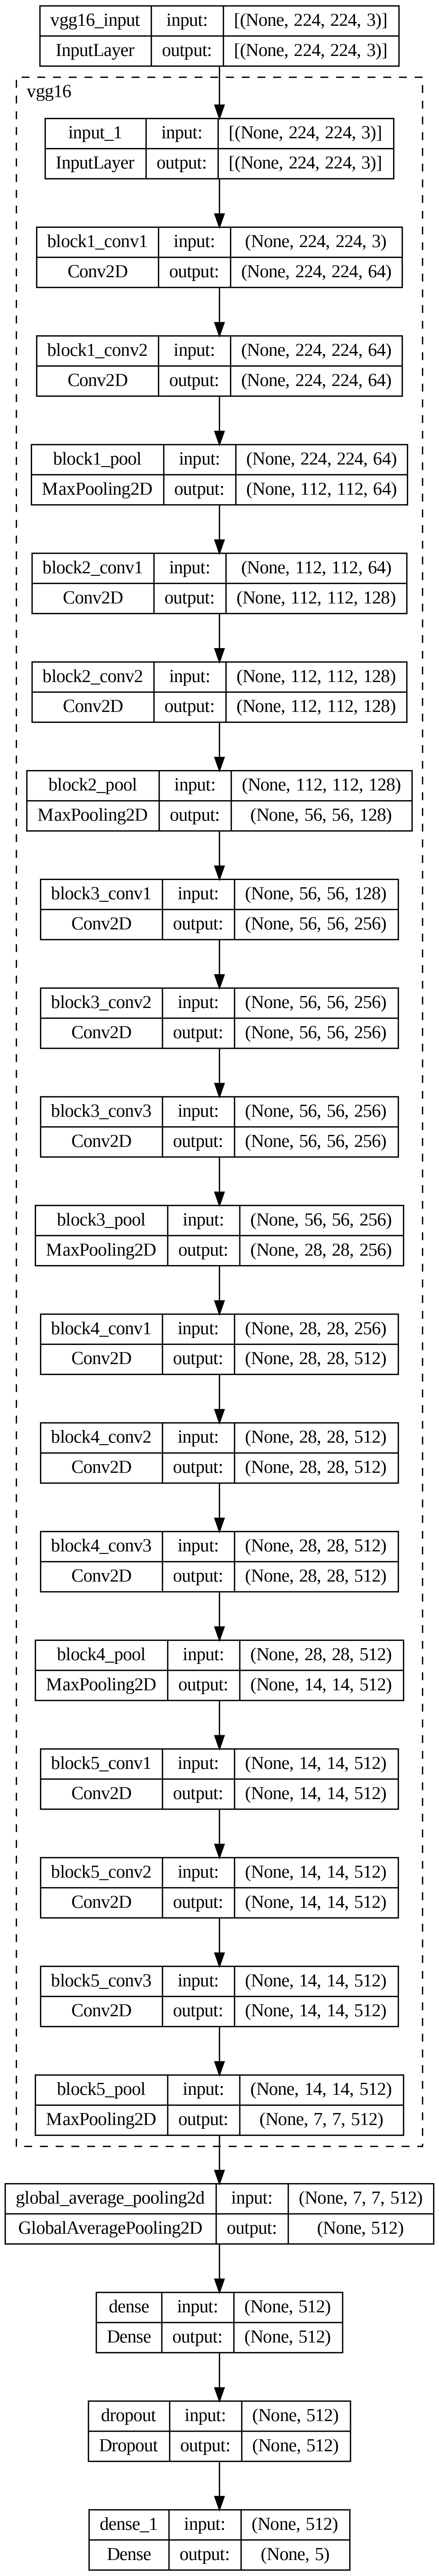

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(
    model,
    to_file='vgg16.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,  # Expand nested models
    rankdir='TB',  # Direction: 'TB' (top to bottom), 'LR' (left to right)
    dpi=300  # Image resolution
)


## Confusion Matrices

In [0]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, hamming_loss

# Define a function to apply thresholds
def apply_thresholds(y_pred, thresholds):
    y_pred_binary = np.zeros_like(y_pred)
    for i in range(y_pred.shape[1]):
        y_pred_binary[:, i] = (y_pred[:, i] > thresholds[i]).astype(int)
    return y_pred_binary

# Thresholds for each class
thresholds = [0.7, 0.6, 0.6, 0.7, 0.2]
# Load the trained model
model = load_model('/content/drive/MyDrive/PFA-Dataset/models/Vgg16.h5')

# Initialize lists to hold true labels and predictions
y_true = []
y_pred = []

# Collect true labels and predictions
for i in range(len(train_generator)):
    X, y = train_generator[i]
    predictions = model.predict(X)
    y_true.extend(y)
    y_pred.extend(predictions)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Binarize the predictions
y_pred_binary = apply_thresholds(y_pred, thresholds)

# Compute the confusion matrix for each class and print them
confusion_matrices = [confusion_matrix(y_true[:, i], y_pred_binary[:, i]) for i in range(y_true.shape[1])]
print('Confusion Matrices')
for i, cm in enumerate(confusion_matrices):
    print(f'Class {["O", "C", "E", "A", "N"][i]}:')
    print(cm)

# Calculate Hamming Loss
hamming = hamming_loss(y_true, y_pred_binary)
print('Hamming Loss:', hamming)

report = classification_report(y_true, y_pred_binary, target_names=['O', 'C', 'E', 'A', 'N'])
print('Classification Report')
print(report)


1/1 [==============================] - 20s 20s/step
Confusion Matrices
Class O:
[[ 431   54]
 [1723  160]]
Class C:
[[1511    0]
 [ 857    0]]
Class E:
[[1252    0]
 [1116    0]]
Class A:
[[ 395    0]
 [1973    0]]
Class N:
[[1347  533]
 [ 412   76]]
Hamming Loss: 0.5631756756756757


NameError: name 'classification_report' is not defined

## retraining vgg16

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Load the saved model
model = load_model('/content/drive/MyDrive/Vgg16.h5')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Train the model using the data generators
history = model.fit(
    train_generator_half2 ,
    epochs=1,
    validation_data=val_generator
)
model.save('/content/drive/Shareddrives/PFA_Dataset/models/vggPretrained_model.h5')


 75/319 [======>.......................] - ETA: 4:49:23 - loss: 0.6071 - accuracy: 0.4450

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, hamming_loss

def apply_thresholds(y_pred, thresholds):
    y_pred_binary = np.zeros_like(y_pred)
    for i in range(y_pred.shape[1]):  # Assuming y_pred has shape (n_samples, n_classes)
        y_pred_binary[:, i] = (y_pred[:, i] > thresholds[i]).astype(int)
    return y_pred_binary

model = load_model('/content/drive/Shareddrives/PFA_Dataset/models/vggPretrained_model.h5')
y_true = []
y_pred = []

for i in range(len(val_generator)):
    X, y = val_generator[i]
    predictions = model.predict(X)

    y_true.extend(y)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, confusion_matrix
print('actual',y_true)
print('predicted',y_pred)
# Binarize the predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the classification report
report = classification_report(y_true, y_pred_binary, target_names=['O', 'C', 'E', 'A', 'N'])
print('Classification Report')
print(report)

# Compute the confusion matrix for each class
confusion_matrices = [confusion_matrix(y_true[:, i], y_pred_binary[:, i]) for i in range(y_true.shape[1])]

# Print the confusion matrices
print('Confusion Matrices')
for i, cm in enumerate(confusion_matrices):
    print(f'Class {["O", "C", "E", "A", "N"][i]}:')
    print(cm)

Classification Report
              precision    recall  f1-score   support

           O       0.68      1.00      0.81      3470
           C       0.56      1.00      0.72      2867
           E       0.00      0.00      0.00      2028
           A       0.64      1.00      0.78      3272
           N       0.00      0.00      0.00       721

   micro avg       0.63      0.78      0.70     12358
   macro avg       0.38      0.60      0.46     12358
weighted avg       0.49      0.78      0.60     12358
 samples avg       0.63      0.78      0.67     12358

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Confusion Matrices
Class O:
[[   0 1618]
 [   0 3470]]
Class C:
[[   0 2221]
 [   0 2867]]
Class E:
[[3059    1]
 [2028    0]]
Class A:
[[   0 1816]
 [   0 3272]]
Class N:
[[4367    0]
 [ 721    0]]